# Ames Housing Dataset - Intro and Data Preparation

> Gianmaria Pizzo - 872966@stud.unive.it

These notebooks represent the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).


---

## Structure of this notebook

This notebook covers the following points
* Domain Research, Context of Data
* Imports and Globals
* Data loading 
* Preliminary Dataset Overview
    * Numerical Features
    * Categorical Features
* Correction of possible errors and coherence check 
* Some preliminary feature creation


---

# Problem Statement 


## Goal - Regression on `Sale_Price`

The project's goal is to build two or models for a prediction task where the target is the `Sale_Price` feature from the [Ames Housing Dataset](https://www.openml.org/search?type=data&status=active&id=43926&sort=runs).

## Problems - What do we know?
Facing a dataset for the first can be challenging as we lack some knowledge:
* We are focusing on a particular geographical area, which we are not familiar with;
* We are focusing on a market we have no prior domain-knowledge of;

Therefore, we have not a clue of how the market is going to behave, nor we know what dictates a change in `Sale_Price`. While the first can be hardly tracked, we can find out about the latter two through data exploration and domain research.

As we know, datasets rarely are perfect, so we must perform some magic!

Let us start from the basics: researching information

---

# Domain Research

Domain research should be the very first step for any project of this kind as it provides a general insight on how the domain behaves, when it comes to data.

## Context of Data: Ames, Iowa (USA)

As the name of the repository suggests, we are looking at a instances of houses which are located in *Ames, Iowa (USA)*. 

From Wikipedia we know that: 

*Ames (/eɪmz/) is a city in Story County, Iowa, United States, located approximately 30 miles (48 km) north of Des Moines in central Iowa. It is best known as the home of Iowa State University (ISU), with leading agriculture, design, engineering, and veterinary medicine colleges. A United States Department of Energy national laboratory, Ames Laboratory, is located on the ISU campus. According to the 2020 census, Ames had a population of 66,427, making it the state's ninth largest city. Iowa State University was home to 27,854 students as of spring 2023, which make up approximately one half of the city's population* 

But this is not a sufficient insight for our goal, as the description lacks information about the real estate context. This mean we might need a more general rule, such as house price assessment in U.S.A.

## House Pricing Method (USA) - Predicting `Sale_Price`

After an extensive research I found out the main driving factors for house prices:
1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. The local market and economic change
7. Mortgage interest rate

However, under this scenario the dataset is not exhaustive. Some aspects such as the local market, and interest rates are hard to guess, although adding features and transformations can reinforce the importance of some features or even include new hidden trends when possible.

## Ames Housing Dataset - What we know so far

As the referenced repository lacks of a detailed description, I went on looking for a better version that you can find [here](https://www.openml.org/search?type=data&sort=runs&id=42165&status=active) thanks to [Thomas Schmitt](https://www.openml.org/search?type=user&id=3422&sort=date)

The dataset presents 2930 instances, representing buildings which were sold in Ames, Iowa. 

The number of features included are exactly 81.
* 35 `float64`
* 46 `object`

These features include information for each entry, about the structure of the house, its surroundings, access to the road, location and sale conditions etc... 

The presence of many object features, bring some issues to the table:
* Representing a quality scales, and labels is hard and usually is achieved through heuristics. 
* The encoding can get messy for regular categorical variables, the increase in the number of features can lead to overfitting and increased variance in our predictions.
* The encoding of categorical features is strictly related to the model we are trying to build. For example, we cannot feed a one-hot-encoding of all the categorical features to a tree-based model as it would create a sparse decision tree.
* Miscellaneous features and their values might be hard to consider as they count only for some instances, which are usually outliers, 
* Longitude and Latitude cannot be used to train models as they lead to overfitting, but cannot be excluded as they are needed for edges creation 

Nevertheless, there are still plenty of numeric columns, which happen to be some of the most important ones as the domain research suggests.

This is indeed, a very complete dataset. In fact, it is presented without any `Nan` values, which is not the case for other versions of the same dataset. This could mean the values were replaced with zeros, or the information was never provided to begin with. This resulted in an ambiguous version of the dataset.

Thanks to a notebook for a similar competition (see [Exploratory Data Analysis of Housing in Ames, Iowa](https://www.kaggle.com/code/leeclemmer/exploratory-data-analysis-of-housing-in-ames-iowa)), I found out some more interesting information about the nature of the data:
* First of all some of the features are missing, but they are not fundamental for this task. 
* However, the data has been gathered between 2006 and 2010 but there is no information regarding whether one house appears more than once. Even though this is not relevant from a training point of view, as the state of the house dictates the price, it can be a problem for prediction as two instances of the same house (before and after remodeling) can have a very big gap in terms of `Sale_Price`, while their features can be almost always the same. 
* Furthermore, there are some warnings about instances which are not residential houses and could deviate the regression.

We can finally start looking at the data now.

---

# Environment, Imports and Global Variables

This project requires to satisfy the following conditions in order to run properly:
* The required libraries must be installed
* The notebooks and dataset files must be in the same directory

For this project I use both matplotlib and seaborn as they offer a wide variety of data visualization techniques and plots

In [7]:
# Interactive
%matplotlib notebook
# Static
# %matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore') 

We need to set the right directories to separate the notebooks from the resources

In [8]:
# Working folder, where this file is at
# It should be in the root directory
WORKING_DIR = os.getcwd()

# Resources folder
# It should be a subpath of root directory
RESOURCES_DIR = os.path.join(os.getcwd(), 'resources')

# Must be created if not exists
if not os.path.exists(RESOURCES_DIR):
    os.mkdir(RESOURCES_DIR)

## Dataset Loading

Now, in the current path there should be a `[project]/resources/` folder with the `ames_housing.arff` file

In [11]:
from scipy.io import arff

# Read the data
data = arff.loadarff(os.path.join(RESOURCES_DIR, "ames_housing.arff"))

## Dataset Overview

If the import has not failed we can get our first insights on the dataset. 

In [12]:
# Get the actual dataset
df = pd.DataFrame(data[0])
print('Our dataset has {0} rows and {1} columns.'.format(df.shape[0], df.shape[1]))

Our dataset has 2930 rows and 81 columns.


This corresponds perfectly to what we expected! `data[0]` is exactly the dataset itself. 
While `data[1]` contains the information about the features' values.

In [14]:
data[1]

Dataset: R_data_frame
	MS_SubClass's type is nominal, range is ('One_Story_1946_and_Newer_All_Styles', 'One_Story_1945_and_Older', 'One_Story_with_Finished_Attic_All_Ages', 'One_and_Half_Story_Unfinished_All_Ages', 'One_and_Half_Story_Finished_All_Ages', 'Two_Story_1946_and_Newer', 'Two_Story_1945_and_Older', 'Two_and_Half_Story_All_Ages', 'Split_or_Multilevel', 'Split_Foyer', 'Duplex_All_Styles_and_Ages', 'One_Story_PUD_1946_and_Newer', 'One_and_Half_Story_PUD_All_Ages', 'Two_Story_PUD_1946_and_Newer', 'PUD_Multilevel_Split_Level_Foyer', 'Two_Family_conversion_All_Styles_and_Ages')
	MS_Zoning's type is nominal, range is ('Floating_Village_Residential', 'Residential_High_Density', 'Residential_Low_Density', 'Residential_Medium_Density', 'A_agr', 'C_all', 'I_all')
	Lot_Frontage's type is numeric
	Lot_Area's type is numeric
	Street's type is nominal, range is ('Grvl', 'Pave')
	Alley's type is nominal, range is ('Gravel', 'No_Alley_Access', 'Paved')
	Lot_Shape's type is nominal, range is 

However, we have no need for it as their description has already been provided.

In [16]:
# Delete it from memory
del data

### Sorting for a better visualization

Before actually getting into the data, we want to make the dataset readable and well organized. Thus, we will sort its column alphabetically and move the `Sale_Price` to the very end. 

This is just for personal tastes, I like to have the columns in alphabetical order and the last column as the target column, since later this will be the best way to display the correlation matrix.

In [18]:
def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically 

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
      col = dataset.pop(last_label)
      dataset.insert(dataset.shape[1], last_label, col)
    return dataset

In [19]:
df = sort_alphabetically(df, 'Sale_Price')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Alley               2930 non-null   object 
 1   Bedroom_AbvGr       2930 non-null   float64
 2   Bldg_Type           2930 non-null   object 
 3   BsmtFin_SF_1        2930 non-null   float64
 4   BsmtFin_SF_2        2930 non-null   float64
 5   BsmtFin_Type_1      2930 non-null   object 
 6   BsmtFin_Type_2      2930 non-null   object 
 7   Bsmt_Cond           2930 non-null   object 
 8   Bsmt_Exposure       2930 non-null   object 
 9   Bsmt_Full_Bath      2930 non-null   float64
 10  Bsmt_Half_Bath      2930 non-null   float64
 11  Bsmt_Qual           2930 non-null   object 
 12  Bsmt_Unf_SF         2930 non-null   float64
 13  Central_Air         2930 non-null   object 
 14  Condition_1         2930 non-null   object 
 15  Condition_2         2930 non-null   object 
 16  Electr

Again, the description was right about the missing values. But we will still need to check them later to figure out whether some might be misleading.

### Some context: Ames, Iowa

As the dataset provides longitude and latitude, we can exploit it to understand the geographical boundaries of the entries. 

Visualizing the location and the geographical distribution of the data is one approach to double check possible errors and to understand the density of the data.

This is an approach to understand what data we are considering, and which entries have been removed during our exploration. Plus, this can be useful to visualize train and test instances that might be problematic.

Last but not least, this is an elegant way to get a high-level idea about which predictive approach could be the best.

 **Mind that this step could be very heavy on the overall memory and can be avoided**.


In [20]:
import folium
from folium import *

def display_ames_houses(dataset, target='Sale_Price', labels=None, title='Ames, Iowa', map_zoom=None):
    """
    Plots an ad-hoc map of a city
    :param map_zoom: a list of float indicating Latitude and Longitude for initial zoom of the map
    :param labels: list of strings indicating the columns names for Latitude, Longitude, Neighborhood
    :param target: string label of a target numeric value to display
    :param title: title of the map
    :param dataset: pandas.DataFrame containing the labels 'Latitude', 'Longitude', and the target column
    :return: folium.Map
    """
    if dataset is None:
        raise Exception("dataset must be a valid pandas.DataFrame")

    if target is None:
        raise Exception("target must be a string column label present inside dataset")

    if labels is None:
        raise Exception("No labels provided")
    
    labels.append(target)
    subset = dataset[labels]
    city_map = folium.Map(
        location= map_zoom,
        tiles="OpenStreetMap",
        zoom_start=12.45,
        control_scale = True,
        min_lat= subset.Latitude.min(),
        max_lat= subset.Latitude.max(),
        min_lon= subset.Longitude.min(),
        max_lon= subset.Longitude.max()
    )
    title_html = '''<h3 align="center" style="font-size:20px"><b>{0}</b></h3>'''.format(title)
    city_map.get_root().html.add_child(folium.Element(title_html))

    subset.reset_index()
    # Add Pop-Ups
    if 'Neighborhood' in labels:
        for index, row in subset.iterrows():
            coordinates = [row.Latitude, row.Longitude]
            # color based on price, icon_color based on neighborhood
            Marker(location=coordinates, popup='Price: $' + str(row.Sale_Price) + '\n Neighborhood: ' + ((str(row.Neighborhood)).strip('\'b')).replace("_", " "), icon=folium.Icon()).add_to(city_map)
    else:
        for index, row in subset.iterrows():
            coordinates = [row.Latitude, row.Longitude]
            # color based on price, icon_color based on neighborhood
            Marker(location=coordinates, popup='Price: $' + str(row.Sale_Price), icon=folium.Icon()).add_to(city_map)
    return city_map

In [ ]:
display_ames_houses(df, target='Sale_Price', labels=['Latitude', 'Longitude', 'Neighborhood'], map_zoom=[42.030781, -93.631912])

Now that we have an idea of the context we can proceed with the real deal

## Numeric Features Overview

First of all let's give a look at the numeric features, which are easier to interpret.

I provided a function to display all the numeric features and their values' distributions through some binned histplots. This aims at giving a rough idea of the possible issues. 

All these kinds of functions will be necessary later, to double check the final output.

In [27]:
def plot_frequency_distr_numeric(dataset, exclude = None, include_kde=False, plot_cols=2, notebook_fig_size=None, adjust=None):
    """
    Given a dataset, it plots the frequency distributions of its numeric features through histograms from seaborn
    :param exclude: a string list representing the columns to exclude
    :param include_kde: boolean representing whether to include kde
    :param dataset: pandas dataframe
    :param plot_cols: count of plots per column
    :param notebook_fig_size: dictionary of integers including keys 'width', 'height' which represent the measures in inches for notebook display purposes
    :param adjust: dictionary of float including keys 'left', 'right', 'top', 'bottom', 'wspace', 'hspace' which are used to space the different plots between them
    """
    # Numeric dataframe
    num_df = dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    
    if exclude is not None:
        num_df = num_df.drop(exclude, axis=1)
    
    # Set subplot shape
    fig, axes = plt.subplots(nrows = int(np.ceil(num_df.shape[1]/plot_cols)), ncols = plot_cols, figsize=(9,2))
    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()
    
    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(10, 40)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))
    
    # Plot distribution for each feature
    for ax, col in zip(axes, num_df.columns):
        sns.histplot(data=num_df, y=col, ax = ax, color='cornflowerblue', kde=include_kde, stat='count')
        ax.set_title(col.replace("_", " ")+'\'s Distribution', fontweight='bold')
        ax.set_ylabel('Values')
        ax.set_xlabel('Count')
        
    # Adjust spacing between plots
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.05, wspace=0.4, hspace=0.9)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass

<IPython.core.display.Javascript object>


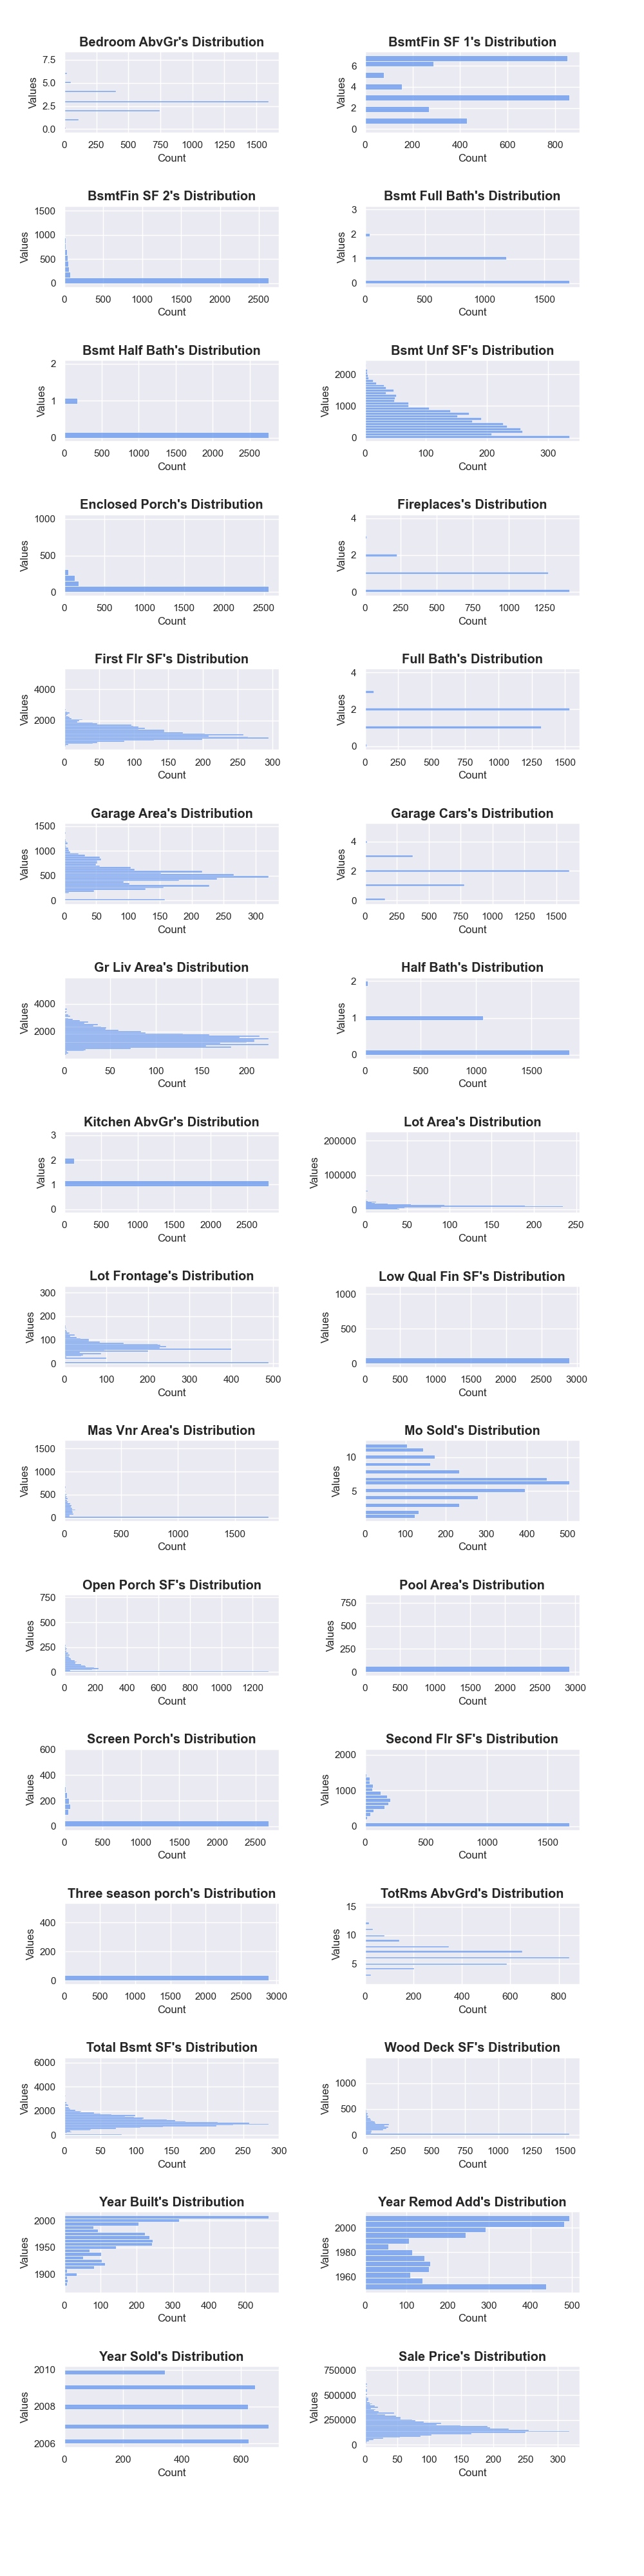

In [28]:
plot_frequency_distr_numeric(df, exclude = ['Latitude', 'Longitude', 'Misc_Val'])

The first things we notice from this is that 
* Most of the distributions are skewed and could benefit from some log transformation or box-cox transformation
    * Eventually they could be paired with a sentinel value for the absence or presence of an attribute
* There are many attributes which lack values other than zero.

As we said before, this is problematic but we have no clue (as for now) on how to deal with this. Some of them can be just used as dummy variables to encode the fact a feature could be present, but the evidence is very low and highly uncorrelated with the `Sale_Price` (i.e. `Three_Seasons_Porch`)

Let us first check some statistics


In [31]:
df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).describe()

Bedroom_AbvGr  BsmtFin_SF_1  BsmtFin_SF_2  Bsmt_Full_Bath  \
count    2930.000000   2930.000000   2930.000000     2930.000000   
mean        2.854266      4.177474     49.705461        0.431058   
std         0.827731      2.233372    169.142089        0.524762   
min         0.000000      0.000000      0.000000        0.000000   
25%         2.000000      3.000000      0.000000        0.000000   
50%         3.000000      3.000000      0.000000        0.000000   
75%         3.000000      7.000000      0.000000        1.000000   
max         8.000000      7.000000   1526.000000        3.000000   

       Bsmt_Half_Bath  Bsmt_Unf_SF  Enclosed_Porch   Fireplaces  First_Flr_SF  \
count     2930.000000  2930.000000     2930.000000  2930.000000   2930.000000   
mean         0.061092   559.071672       23.011604     0.599317   1159.557679   
std          0.245175   439.540571       64.139059     0.647921    391.890885   
min          0.000000     0.000000        0.000000     0.000000    334.000000   
25%          0.000000   219.000000        0.000000     0.000000    876.250000   
50%          0.000000   465.500000        0.000000     1.000000   1084.000000   
75%          0.000000   801.750000        0.000000     1.000000   1384.000000   
max          2.000000  2336.000000     1012.000000     4.000000   5095.000000   

         Full_Bath  ...  Screen_Porch  Second_Flr_SF  Three_season_porch  \
count  2930.000000  ...   2930.000000    2930.000000         2930.000000   
mean      1.566553  ...     16.002048     335.455973            2.592491   
std       0.552941  ...     56.087370     428.395715           25.141331   
min       0.000000  ...      0.000000       0.000000            0.000000   
25%       1.000000  ...      0.000000       0.000000            0.000000   
50%       2.000000  ...      0.000000       0.000000            0.000000   
75%       2.000000  ...      0.000000     703.750000            0.000000   
max       4.000000  ...    576.000000    2065.000000          508.000000   

       TotRms_AbvGrd  Total_Bsmt_SF  Wood_Deck_SF   Year_Built  \
count    2930.000000    2930.000000   2930.000000  2930.000000   
mean        6.443003    1051.255631     93.751877  1971.356314   
std         1.572964     440.968018    126.361562    30.245361   
min         2.000000       0.000000      0.000000  1872.000000   
25%         5.000000     793.000000      0.000000  1954.000000   
50%         6.000000     990.000000      0.000000  1973.000000   
75%         7.000000    1301.500000    168.000000  2001.000000   
max        15.000000    6110.000000   1424.000000  2010.000000   

       Year_Remod_Add    Year_Sold     Sale_Price  
count     2930.000000  2930.000000    2930.000000  
mean      1984.266553  2007.790444  180796.060068  
std         20.860286     1.316613   79886.692357  
min       1950.000000  2006.000000   12789.000000  
25%       1965.000000  2007.000000  129500.000000  
50%       1993.000000  2008.000000  160000.000000  
75%       2004.000000  2009.000000  213500.000000  
max       2010.000000  2010.000000  755000.000000  

[8 rows x 35 columns]

From the table, it is easy to see that we have a problematic dataset from a values'distribution point of view. However we will get deeper into that side on the next notebook.

For what concerns the skewness:

In [69]:
# Util function for pretty printing
def print_num_col_skewness(dataset, exclude = None):
    """
    Prints the skewness of the numeric columns in the dataset
    : param dataset: pandas.DataFrame
    : param exclude: list of str representing column labels to exclude
    : returns: None
    """
    for x in dataset.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']):
        if exclude is not None and x in exclude:
            continue
        else:
            print("Skewness of " + x + ": \n" + str(scipy.stats.skew(df[""+x])) + "\n")
    pass

In [70]:
print_num_col_skewness(df, exclude = ['Latitude', 'Longitude', 'Misc_Val'])

Skewness of Bedroom_AbvGr: 
0.30553769035566597

Skewness of BsmtFin_SF_1: 
0.08911009666138348

Skewness of BsmtFin_SF_2: 
4.138673580995156

Skewness of Bsmt_Full_Bath: 
0.617411423419396

Skewness of Bsmt_Half_Bath: 
3.9403706782664814

Skewness of Bsmt_Unf_SF: 
0.922572362659496

Skewness of Enclosed_Porch: 
4.012390205634154

Skewness of Fireplaces: 
0.7388367095522606

Skewness of First_Flr_SF: 
1.4686762661218558

Skewness of Full_Bath: 
0.1718640349156229

Skewness of Garage_Area: 
0.23994167112208759

Skewness of Garage_Cars: 
-0.22104927953966302

Skewness of Gr_Liv_Area: 
1.2734573491164038

Skewness of Half_Bath: 
0.6973558240143646

Skewness of Kitchen_AbvGr: 
4.311615838595926

Skewness of Lot_Area: 
12.814333637733153

Skewness of Lot_Frontage: 
0.025051361901111895

Skewness of Low_Qual_Fin_SF: 
12.111956844115396

Skewness of Mas_Vnr_Area: 
2.617963998324404

Skewness of Mo_Sold: 
0.19249745018212133

Skewness of Open_Porch_SF: 
2.5340877554403782

Skewness of Pool_Are

It is very high for some values, highlighting the absence of many normally-distributed features

## Categorical Features Overview

### Categorical features recap
Before plotting categorical features, which might be unnecessary, we should look out for their meaning. In fact, categorical features have some special subcases:
* **Nominal features**, describe a name, label or category **without natural order**;
* **Ordinal features**, variables whose values are defined by an **order relation** between the different categories;

From another point of view we also can define **Dichotomous features**, categorical variables with two categories or levels;
* *Discrete Dichotomous* features, categorical variables with two categories or levels and **nothing in between them**. 
    * Binary features, variables assigned either a 0 or a 1.
* *Continuous Dichotomous* features, categorical variables **with possibilities in between** the two (extreme) categories.

### Our case

The problem here is we have mix of these features which can be confusing when it is time for encoding, since the difference between ordinal features and continuous dichotomous features can be subtle.

Once again, we focus our attention on the distribution as a preliminary step

In [109]:
from itertools import zip_longest

# We use a decoded version of the dataset to display the labels better
def decode_byte_str(dataset):
    """
    Decodes the dataset's object features in place
    : param dataset: a pandas.DataFrame
    : returns: None
    """
    categorical = df.select_dtypes(object)
    categorical = categorical.stack().str.decode('utf-8').unstack()
    for col in categorical:
        dataset[col] = categorical[col]
    pass

def barplot_categ(dataset):
    """
    Produces a barplot for a dataset, including only the object types
    : param dataset: a pandas.DatFrame
    : returns: None
    """
    # Categorical Features Only 
    categorical_data = dataset.select_dtypes(object)
    # Rows
    n = categorical_data.shape[1]
    # Params for subplots
    nrows, ncols = (int(np.ceil(n / 2))+1, 2)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9.9, 60))
    
    for feature_name, ax in zip_longest(categorical_data, axs.ravel()):
        if feature_name is None:
            # Avoid showing axis
            ax.axis("off")
            continue

        ax = categorical_data[feature_name].value_counts().plot.barh(ax=ax, color='cornflowerblue')
        ax.set_title(feature_name + '\'s Frequency', fontweight='bold')
        ax.set_xlabel('Count', fontsize = 8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        plt.setp(ax.get_yticklabels(), rotation=40)

    plt.subplots_adjust(left=0.2,
                    bottom=0.02,
                    right=0.9,
                    top=0.98,
                    wspace=0.9,
                    hspace=0.9)
    pass


def boxplot_categ(dataset, target):
    """
    Produces a target related boxplot for a dataset, including only the object types
    : param dataset: a pandas.DatFrame
    : param target: a string label for a column
    : returns: None
    """
    # Categorical Features Only 
    categorical_data = dataset.select_dtypes(object)
    # Rows
    n = categorical_data.shape[1]
    # Params for subplots
    nrows, ncols = (n, 1)
    
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, n*7))
    
    for feature_name, ax in zip_longest(categorical_data, axs.ravel()):
        if feature_name is None:
            # Avoid showing axis
            ax.axis("off")
            continue
        
        ax = dataset[[target, feature_name]].boxplot(ax=ax, rot = 45,
                                                     column=target,
                                                     by=feature_name)
        ax.set_title(feature_name + ' Boxplot', fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)
        plt.setp(ax.get_yticklabels(), rotation=40)

    plt.subplots_adjust(left=0.2,
                    bottom=0.03,
                    right=0.9,
                    top=0.96,
                    wspace=0.7,
                    hspace=0.7)
    pass

<IPython.core.display.Javascript object>


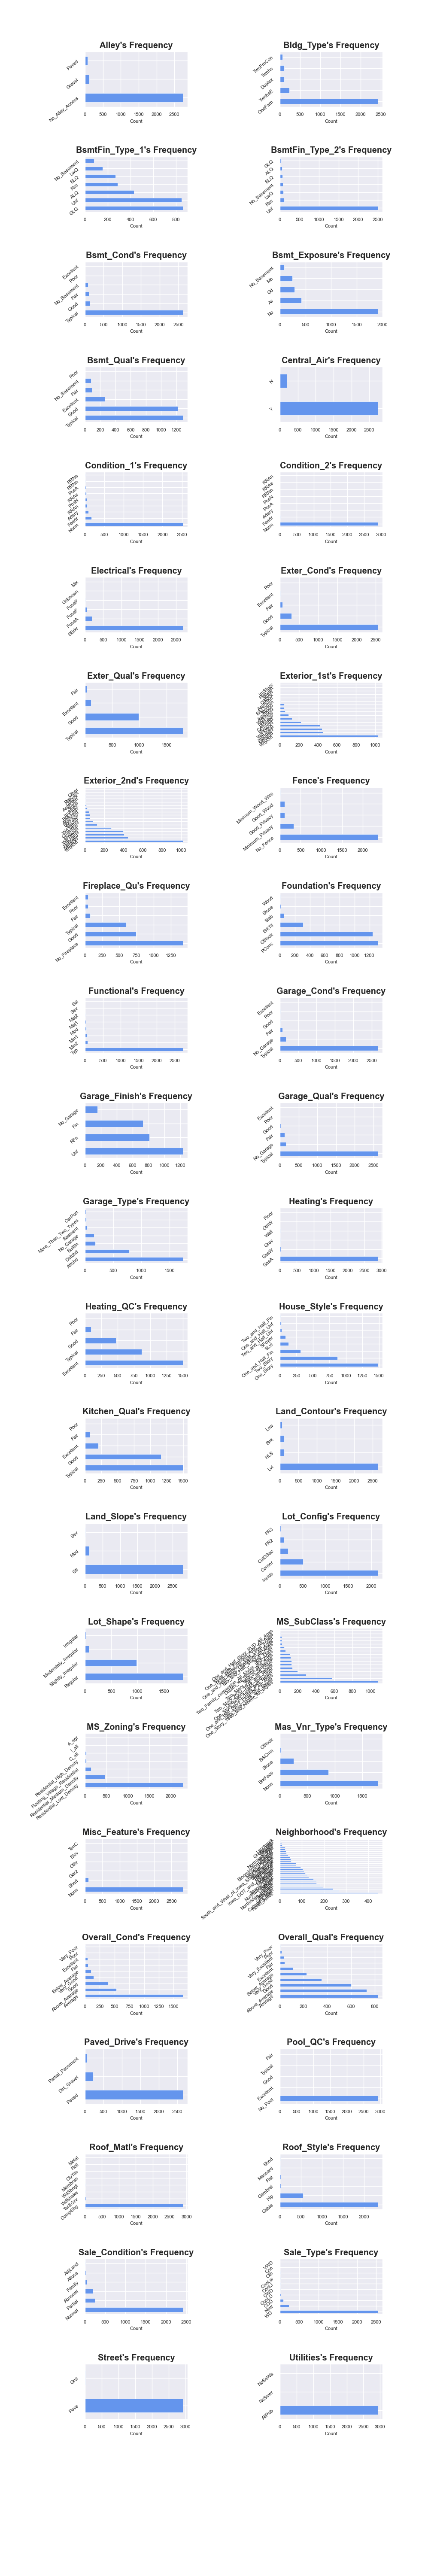

In [74]:
temp=df.copy()
decode_byte_str(dataset=temp)
barplot_categ(temp)

Again we find some features which do not show much diversity in their observations, which corroborates the fact that there might be a pattern.

We can notice two major aspects from this plot:
* First, we see that there are plenty of feature were one value is heavily overrpresented.
* A number of categorical features that are really ordinal features

I have also provided a boxplot, and the resulting plots confirm what we just said.

<IPython.core.display.Javascript object>


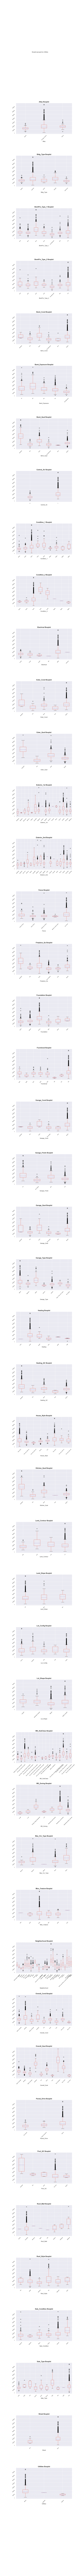

In [111]:
boxplot_categ(temp, "Sale_Price")

In [113]:
del temp

However, the encoding will take place later, at the end of the EDA.

## Data Correction, Coherence Check and some Feature Engineering

At this point just by looking at the plots above we notice discrepancies between features. Here we try to correct them and to add some features or indicators that could be of help later.

Most of them concern
* Zoning Class
* Living Area features
* Basement related features
* Garage related features
* Fireplace related features
* Sale Condition

In [114]:
def get_cols(dataset, col_substring):
    cols = df.columns.tolist()
    col_lst = []
    for i in cols:
        if col_substring in i:
            col_lst.append(i)
    return col_lst

### Zoning Class

We want to remove all the data that does not concern house prices, namely non-residential buildings.

In [115]:
df['MS_Zoning'].unique()

array([b'Residential_Low_Density', b'Residential_High_Density',
       b'Floating_Village_Residential', b'Residential_Medium_Density',
       b'C_all', b'I_all', b'A_agr'], dtype=object)

We notice, as predicted, that some buildings are not residential.

In [116]:
df[(df['MS_Zoning'] == b'C_all') | ((df['MS_Zoning'] == b'I_all') | (df['MS_Zoning'] == b'A_agr'))]

Alley  Bedroom_AbvGr    Bldg_Type  BsmtFin_SF_1  \
213   b'No_Alley_Access'            4.0    b'OneFam'           6.0   
304   b'No_Alley_Access'            2.0    b'OneFam'           7.0   
305             b'Paved'            2.0    b'OneFam'           7.0   
306   b'No_Alley_Access'            2.0    b'OneFam'           7.0   
307   b'No_Alley_Access'            3.0    b'OneFam'           7.0   
720   b'No_Alley_Access'            2.0    b'OneFam'           7.0   
726   b'No_Alley_Access'            2.0    b'OneFam'           6.0   
727   b'No_Alley_Access'            2.0    b'OneFam'           7.0   
942   b'No_Alley_Access'            2.0    b'OneFam'           7.0   
943            b'Gravel'            2.0    b'OneFam'           7.0   
945   b'No_Alley_Access'            1.0    b'OneFam'           5.0   
1553  b'No_Alley_Access'            2.0    b'OneFam'           5.0   
1554  b'No_Alley_Access'            2.0    b'OneFam'           7.0   
1555            b'Paved'            3.0    b'OneFam'           7.0   
1556  b'No_Alley_Access'            2.0    b'OneFam'           7.0   
1557  b'No_Alley_Access'            2.0    b'OneFam'           7.0   
1558  b'No_Alley_Access'            3.0    b'OneFam'           7.0   
1610  b'No_Alley_Access'            4.0    b'OneFam'           7.0   
1998  b'No_Alley_Access'            4.0  b'TwoFmCon'           6.0   
2242  b'No_Alley_Access'            4.0  b'TwoFmCon'           7.0   
2243  b'No_Alley_Access'            3.0    b'OneFam'           3.0   
2244  b'No_Alley_Access'            2.0    b'OneFam'           1.0   
2669  b'No_Alley_Access'            2.0    b'OneFam'           7.0   
2878  b'No_Alley_Access'            3.0    b'OneFam'           6.0   
2879  b'No_Alley_Access'            2.0    b'OneFam'           5.0   
2880  b'No_Alley_Access'            1.0    b'OneFam'           2.0   
2881  b'No_Alley_Access'            4.0  b'TwoFmCon'           7.0   
2882  b'No_Alley_Access'            2.0    b'OneFam'           7.0   
2903  b'No_Alley_Access'            3.0    b'OneFam'           5.0   

      BsmtFin_SF_2  BsmtFin_Type_1  BsmtFin_Type_2       Bsmt_Cond  \
213            0.0          b'Rec'          b'Unf'      b'Typical'   
304            0.0          b'Unf'          b'Unf'      b'Typical'   
305            0.0          b'Unf'          b'Unf'      b'Typical'   
306            0.0          b'Unf'          b'Unf'      b'Typical'   
307            0.0          b'Unf'          b'Unf'      b'Typical'   
720            0.0          b'Unf'          b'Unf'      b'Typical'   
726            0.0          b'Rec'          b'Unf'      b'Typical'   
727            0.0          b'Unf'          b'Unf'      b'Typical'   
942            0.0          b'Unf'          b'Unf'         b'Fair'   
943            0.0          b'Unf'          b'Unf'      b'Typical'   
945            0.0  b'No_Basement'  b'No_Basement'  b'No_Basement'   
1553           0.0  b'No_Basement'  b'No_Basement'  b'No_Basement'   
1554           0.0          b'Unf'          b'Unf'         b'Fair'   
1555           0.0          b'Unf'          b'Unf'      b'Typical'   
1556           0.0          b'Unf'          b'Unf'      b'Typical'   
1557           0.0          b'Unf'          b'Unf'      b'Typical'   
1558           0.0          b'Unf'          b'Unf'         b'Fair'   
1610           0.0          b'Unf'          b'Unf'      b'Typical'   
1998           0.0          b'Rec'          b'Unf'         b'Fair'   
2242           0.0          b'Unf'          b'Unf'      b'Typical'   
2243           0.0          b'GLQ'          b'Unf'      b'Typical'   
2244           0.0          b'ALQ'          b'Unf'      b'Typical'   
2669           0.0          b'Unf'          b'Unf'         b'Fair'   
2878           0.0          b'Rec'          b'Unf'      b'Typical'   
2879           0.0  b'No_Basement'  b'No_Basement'  b'No_Basement'   
2880           0.0          b'BLQ'          b'Unf'      b'Typical'   
2881           0.0          

As this might cause confusion for our predictions, we want to ignore those instances

In [117]:
# Delete all commercial, agriculture and industrial buildings
df.drop(df[(df['MS_Zoning'] == b'C_all') | ((df['MS_Zoning'] == b'I_all') | (df['MS_Zoning'] == b'A_agr'))].index.tolist(),inplace=True)

### Subclass


In [118]:
df['MS_SubClass'].unique()

array([b'One_Story_1946_and_Newer_All_Styles',
       b'Two_Story_1946_and_Newer', b'One_Story_PUD_1946_and_Newer',
       b'One_and_Half_Story_Finished_All_Ages', b'Split_Foyer',
       b'Two_Story_PUD_1946_and_Newer', b'Split_or_Multilevel',
       b'One_Story_1945_and_Older', b'Duplex_All_Styles_and_Ages',
       b'Two_Family_conversion_All_Styles_and_Ages',
       b'One_and_Half_Story_Unfinished_All_Ages',
       b'Two_Story_1945_and_Older', b'Two_and_Half_Story_All_Ages',
       b'One_Story_with_Finished_Attic_All_Ages',
       b'PUD_Multilevel_Split_Level_Foyer',
       b'One_and_Half_Story_PUD_All_Ages'], dtype=object)

As `MS_Subclass` looks like a mixture of building year, building type and other features, it seems to have little relevance here and safe to ignore.

In [119]:
df.drop(columns=['MS_SubClass'], inplace=True)

### Living area related features

#### Above ground area

For what concerns the living space we can see `Gr_Liv_Area` is exaclty the sum of `First_Flr_SF`, `Second_Flr_SF` and `Low_Qual_Fin_SF`

In [138]:
liv = df[get_cols(df, 'AbvGr') + get_cols(df, 'Flr') + get_cols(df, 'Liv') + get_cols(df, 'Low_Qual_Fin_SF') + get_cols(df, 'Bsmt')+ get_cols(df, 'Price')]
# Coherence
cond_total_error = (df['Gr_Liv_Area'] != (df['First_Flr_SF'] + df['Second_Flr_SF'] + df['Low_Qual_Fin_SF']))
liv[cond_total_error]

Empty DataFrame
Columns: [Bedroom_AbvGr, Kitchen_AbvGr, TotRms_AbvGrd, First_Flr_SF, Second_Flr_SF, Gr_Liv_Area, LowQ_Total_Liv_Ratio, Low_Qual_Fin_SF, Bsmt, BsmtFin_SF_1, BsmtFin_SF_2, BsmtFin_Type_1, BsmtFin_Type_2, Bsmt_Cond, Bsmt_Exposure, Bsmt_Fin_SF, Bsmt_Full_Bath, Bsmt_Half_Bath, Bsmt_Qual, Bsmt_Unf_SF, Total_Bsmt_SF, Sale_Price]
Index: []

[0 rows x 22 columns]

The data is coherent here.

We can add a column to represent the ratio `Low_Qual_Fin_SF/Gr_Liv_Area` to give us an idea of how that affects the price.

In [121]:
df['LowQ_Total_Liv_Ratio'] = df.apply(lambda x: 0.0 if (x['Low_Qual_Fin_SF'] <= 0.0) else (x['Low_Qual_Fin_SF']/x['Gr_Liv_Area']), axis=1)

#### Bedrooms

There are some houses which lack of bedrooms, which is almost never the case.

In [122]:
# No Bedrooms is impossible when
no_bedroom_abvgr = (df['Bedroom_AbvGr'] <=0)
liv[no_bedroom_abvgr]

Bedroom_AbvGr  Kitchen_AbvGr  TotRms_AbvGrd  First_Flr_SF  \
158             0.0            2.0            4.0        1056.0   
232             0.0            1.0            4.0        1332.0   
999             0.0            1.0            5.0        1593.0   
1385            0.0            2.0            6.0        1258.0   
2118            0.0            1.0            5.0        1743.0   
2279            0.0            1.0            3.0         936.0   
2522            0.0            1.0            5.0        1842.0   
2723            0.0            1.0            3.0         960.0   

      Second_Flr_SF  Gr_Liv_Area  Low_Qual_Fin_SF  BsmtFin_SF_1  BsmtFin_SF_2  \
158             0.0       1056.0              0.0           3.0           0.0   
232           192.0       1524.0              0.0           3.0           0.0   
999             0.0       1593.0              0.0           3.0           0.0   
1385            0.0       1258.0              0.0           3.0           0.0   
2118            0.0       1743.0              0.0           4.0         915.0   
2279            0.0        936.0              0.0           6.0         904.0   
2522            0.0       1842.0              0.0           3.0           0.0   
2723            0.0        960.0              0.0           3.0           0.0   

     BsmtFin_Type_1 BsmtFin_Type_2   Bsmt_Cond Bsmt_Exposure  Bsmt_Full_Bath  \
158          b'GLQ'         b'Unf'  b'Typical'         b'No'             2.0   
232          b'GLQ'         b'Unf'  b'Typical'         b'Gd'             2.0   
999          b'GLQ'         b'Unf'  b'Typical'         b'Av'             1.0   
1385         b'GLQ'         b'Unf'  b'Typical'         b'Av'             2.0   
2118         b'LwQ'         b'GLQ'     b'Good'         b'Gd'             2.0   
2279         b'Rec'         b'GLQ'  b'Typical'         b'Av'             2.0   
2522         b'GLQ'         b'Unf'  b'Typical'         b'Gd'             2.0   
2723         b'GLQ'         b'Unf'     b'Good'         b'Av'             1.0   

      Bsmt_Half_Bath     Bsmt_Qual  Bsmt_Unf_SF  Total_Bsmt_SF  Sale_Price  
158              0.0    b'Typical'          0.0         1056.0    144000.0  
232              0.0       b'Good'         74.0         1332.0    260000.0  
999              0.0  b'Excellent'        440.0         1593.0    286000.0  
1385             0.0       b'Good'          0.0         1198.0    108959.0  
2118             0.0       b'Good'          0.0          966.0    279000.0  
2279             0.0  b'Excellent'          0.0          920.0    140000.0  
2522             0.0  b'Excellent'         32.0         1842.0    385000.0  
2723             1.0    b'Typical'          0.0          648.0    145000.0

We can see that we have 0 bedrooms above ground for these rows but that cannot be true. If we suppose that all the houses have at least one living room, and that bathrooms are not counted as living space, there should be at least one bedroom per house. So we will correct them with the median for each cluster of houses with the same rooms above ground.

In [123]:
df['Bedroom_AbvGr'] = df.apply(lambda x: 1 if((x['TotRms_AbvGrd']== 3) & (x['Bedroom_AbvGr']== 0)) else x['Bedroom_AbvGr'] ,axis=1)
df['Bedroom_AbvGr'] = df.apply(lambda x: 2 if((x['TotRms_AbvGrd']== 4) & (x['Bedroom_AbvGr']== 0)) else x['Bedroom_AbvGr'] ,axis=1)
df['Bedroom_AbvGr'] = df.apply(lambda x: 2 if((x['TotRms_AbvGrd']== 5) & (x['Bedroom_AbvGr']== 0)) else x['Bedroom_AbvGr'] ,axis=1)
df['Bedroom_AbvGr'] = df.apply(lambda x: 3 if((x['TotRms_AbvGrd']== 6) & (x['Bedroom_AbvGr']== 0)) else x['Bedroom_AbvGr'] ,axis=1)

### Basement related features

If we consider `BsmtFin_Type` and `Bsmt_Fin_SF` which are strictly related to each other.
* `BsmtFin_Type` refers to *Rating of basement finished area (if multiple types)*
* `BsmtFin_SF` refers to  *Type x finished square feet*

For a house with `BsmtFin_SF == 0.0` it should be coherent to see either `b'No_Basement'` or `b'Unf'` for `BsmtFin_Type`.

To double check we insert a new feature which might be of use later.

In [124]:
df['Bsmt_Fin_SF'] = df['Total_Bsmt_SF'] - df['Bsmt_Unf_SF']
df['Bsmt'] = df.apply(lambda x: 1 if (x['Total_Bsmt_SF']>0.0) else 0 ,axis=1)

In [125]:
# These rows have no basement.
cond_no_bsmt = ((df['Bsmt_Cond'] == b'No_Basement')|(df['Bsmt_Qual'] == b'No_Basement'))
cond_unf_bsmt = ((df['BsmtFin_Type_1'] == b'Unf')|(df['BsmtFin_Type_2'] == b'Unf'))
# These rows have some finished basements
cond_fin_bsmt = ((df['BsmtFin_SF_1'] == 0.0) | (df['BsmtFin_SF_2'] ==0.0))

In [126]:
# These rows need to be corrected
df['BsmtFin_SF_1'] = df.apply(lambda x: 0.0 if (x['BsmtFin_Type_1']== b'No_Basement') else x['BsmtFin_SF_1'],axis=1)
df['BsmtFin_SF_2'] = df.apply(lambda x: 0.0 if (x['BsmtFin_Type_2']== b'No_Basement') else x['BsmtFin_SF_2'],axis=1)

In [127]:
# Data error, the type 2 should be unfinished
df.drop(df[(df['BsmtFin_SF_2'] ==0.0)&((df['BsmtFin_Type_2'] != b'Unf')&( df['BsmtFin_Type_2'] != b'No_Basement'))].index.tolist(), inplace=True)

### Garage Related Features

Again we cannot have ghost garages and we need to correct those instances!

In [128]:
cond_no_garage = ((df['Garage_Qual'] == b'No_Garage')|(df['Garage_Cond'] == b'No_Garage'))
cond_has_area = (df['Garage_Area'] > 0.0)

# Obvious mistakes or outliers
df.drop(df[cond_no_garage & cond_has_area].index[0], inplace=True)

In [129]:
df['Garage'] = df.apply(lambda x: 0 if (x['Garage_Area']<=0) else 1,axis=1)

### External related features

For what concerns the surroundings of the house itself, we want to be sure to have a way to check the presence of external structures suchs as a porch.

#### Porch and deck

In [130]:
ext_sub = df[get_cols(df, 'Porch')+get_cols(df, 'porch')+ get_cols(df, 'Deck') + get_cols(df, 'Sale_Price')]
ext_sub

Enclosed_Porch  Open_Porch_SF  Screen_Porch  Three_season_porch  \
0                0.0           62.0           0.0                 0.0   
1                0.0            0.0         120.0                 0.0   
2                0.0           36.0           0.0                 0.0   
3                0.0            0.0           0.0                 0.0   
4                0.0           34.0           0.0                 0.0   
...              ...            ...           ...                 ...   
2925             0.0            0.0           0.0                 0.0   
2926             0.0            0.0           0.0                 0.0   
2927             0.0           32.0           0.0                 0.0   
2928             0.0           38.0           0.0                 0.0   
2929             0.0           48.0           0.0                 0.0   

      Wood_Deck_SF  Sale_Price  
0            210.0    215000.0  
1            140.0    105000.0  
2            393.0    172000.0  
3              0.0    244000.0  
4            212.0    189900.0  
...            ...         ...  
2925         120.0    142500.0  
2926         164.0    131000.0  
2927          80.0    132000.0  
2928         240.0    170000.0  
2929         190.0    188000.0  

[2899 rows x 6 columns]

In [131]:
df['Total_Porch_SF'] = df['Enclosed_Porch'] + df['Open_Porch_SF'] + df['Screen_Porch']+ df['Three_season_porch']
df['Porch'] = df.apply(lambda x: 1 if(x['Total_Porch_SF'] > 0.0) else(0), axis=1)
df['Deck'] = df.apply(lambda x: 1 if(x['Wood_Deck_SF'] > 0.0) else(0), axis=1)

---

## The resulting dataset

The resulting dataset has the advantage of less incoherent data and some outliers removal. This can be confirmed through the plots 

In [133]:
df = sort_alphabetically(df, 'Sale_Price')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2899 entries, 0 to 2929
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alley                 2899 non-null   object 
 1   Bedroom_AbvGr         2899 non-null   float64
 2   Bldg_Type             2899 non-null   object 
 3   Bsmt                  2899 non-null   int64  
 4   BsmtFin_SF_1          2899 non-null   float64
 5   BsmtFin_SF_2          2899 non-null   float64
 6   BsmtFin_Type_1        2899 non-null   object 
 7   BsmtFin_Type_2        2899 non-null   object 
 8   Bsmt_Cond             2899 non-null   object 
 9   Bsmt_Exposure         2899 non-null   object 
 10  Bsmt_Fin_SF           2899 non-null   float64
 11  Bsmt_Full_Bath        2899 non-null   float64
 12  Bsmt_Half_Bath        2899 non-null   float64
 13  Bsmt_Qual             2899 non-null   object 
 14  Bsmt_Unf_SF           2899 non-null   float64
 15  Central_Air          

<IPython.core.display.Javascript object>


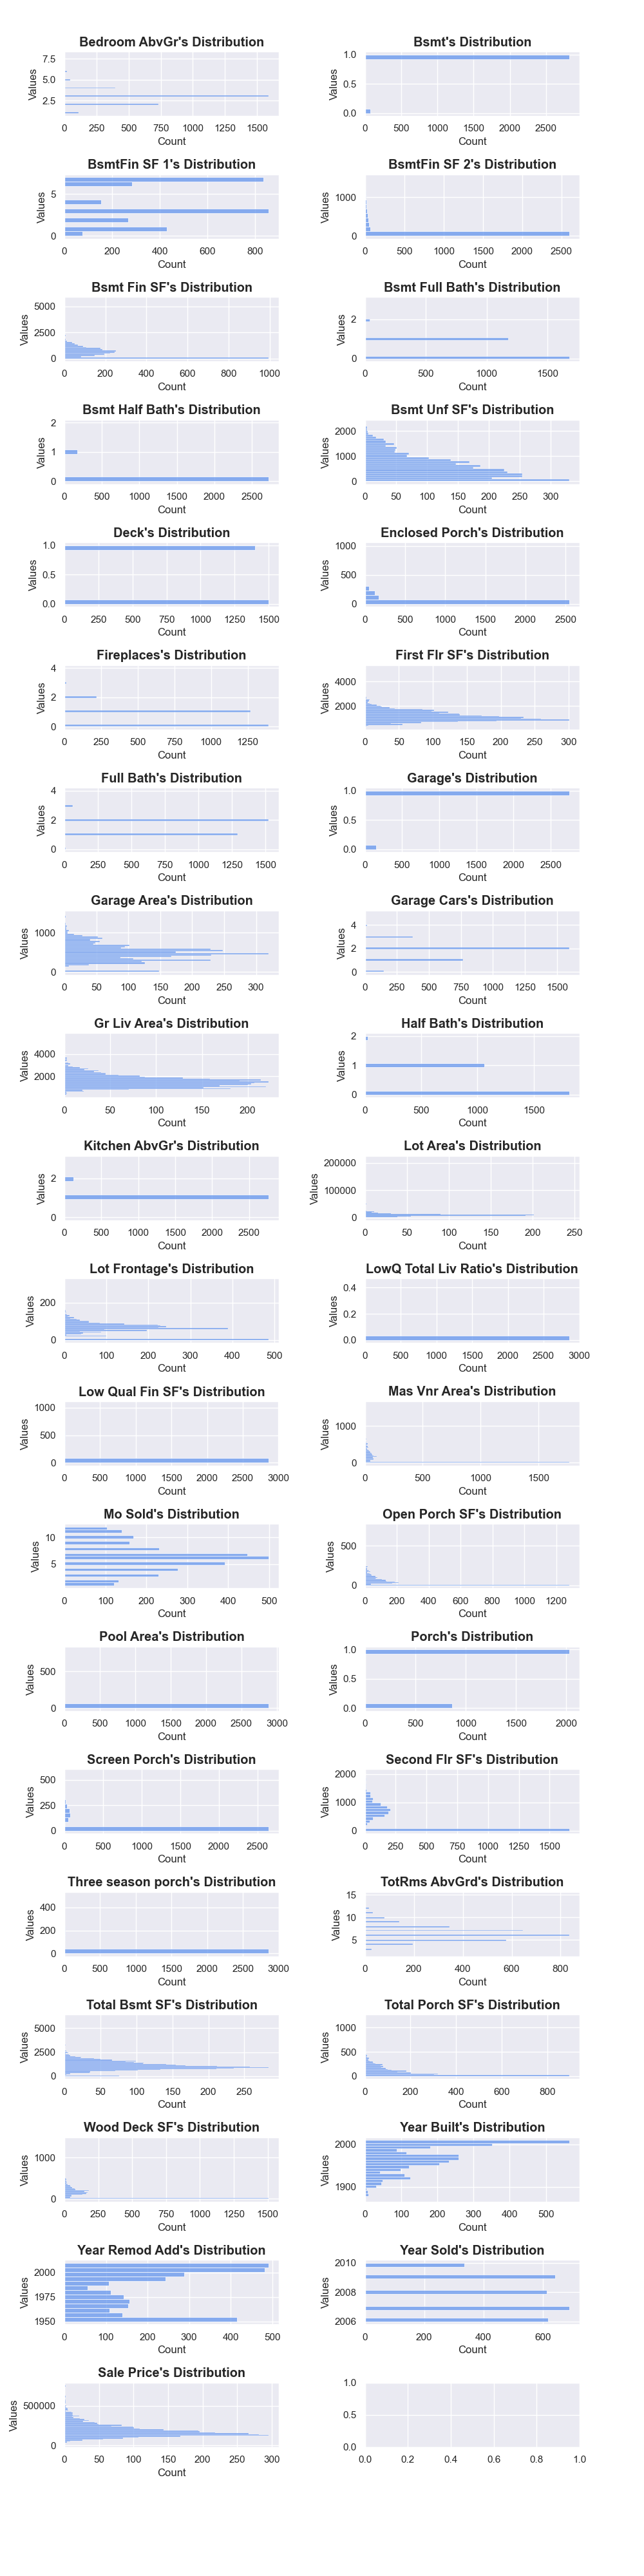

In [134]:
plot_frequency_distr_numeric(df, exclude = ['Latitude', 'Longitude', 'Misc_Val'])

Both the distribution of values and the skewness have improved.

In [135]:
print_num_col_skewness(df, exclude = ['Latitude', 'Longitude', 'Misc_Val'])

Skewness of Bedroom_AbvGr: 
0.40586216981393947

Skewness of Bsmt: 
-5.930569834054176

Skewness of BsmtFin_SF_1: 
0.10961786788486605

Skewness of BsmtFin_SF_2: 
4.12407410850383

Skewness of Bsmt_Fin_SF: 
1.1667376361087463

Skewness of Bsmt_Full_Bath: 
0.6049083296629019

Skewness of Bsmt_Half_Bath: 
3.9300473315350914

Skewness of Bsmt_Unf_SF: 
0.9240681587038051

Skewness of Deck: 
0.07110387883753629

Skewness of Enclosed_Porch: 
4.099519212286747

Skewness of Fireplaces: 
0.7270637707803922

Skewness of First_Flr_SF: 
1.470642159846141

Skewness of Full_Bath: 
0.16652067777748206

Skewness of Garage: 
-4.07941619064811

Skewness of Garage_Area: 
0.2440773449062702

Skewness of Garage_Cars: 
-0.21594587511628868

Skewness of Gr_Liv_Area: 
1.283621818210004

Skewness of Half_Bath: 
0.6868344001255108

Skewness of Kitchen_AbvGr: 
4.340740404755574

Skewness of Lot_Area: 
13.000218730265741

Skewness of Lot_Frontage: 
0.027013296857746817

Skewness of LowQ_Total_Liv_Ratio: 
11.33724

<IPython.core.display.Javascript object>


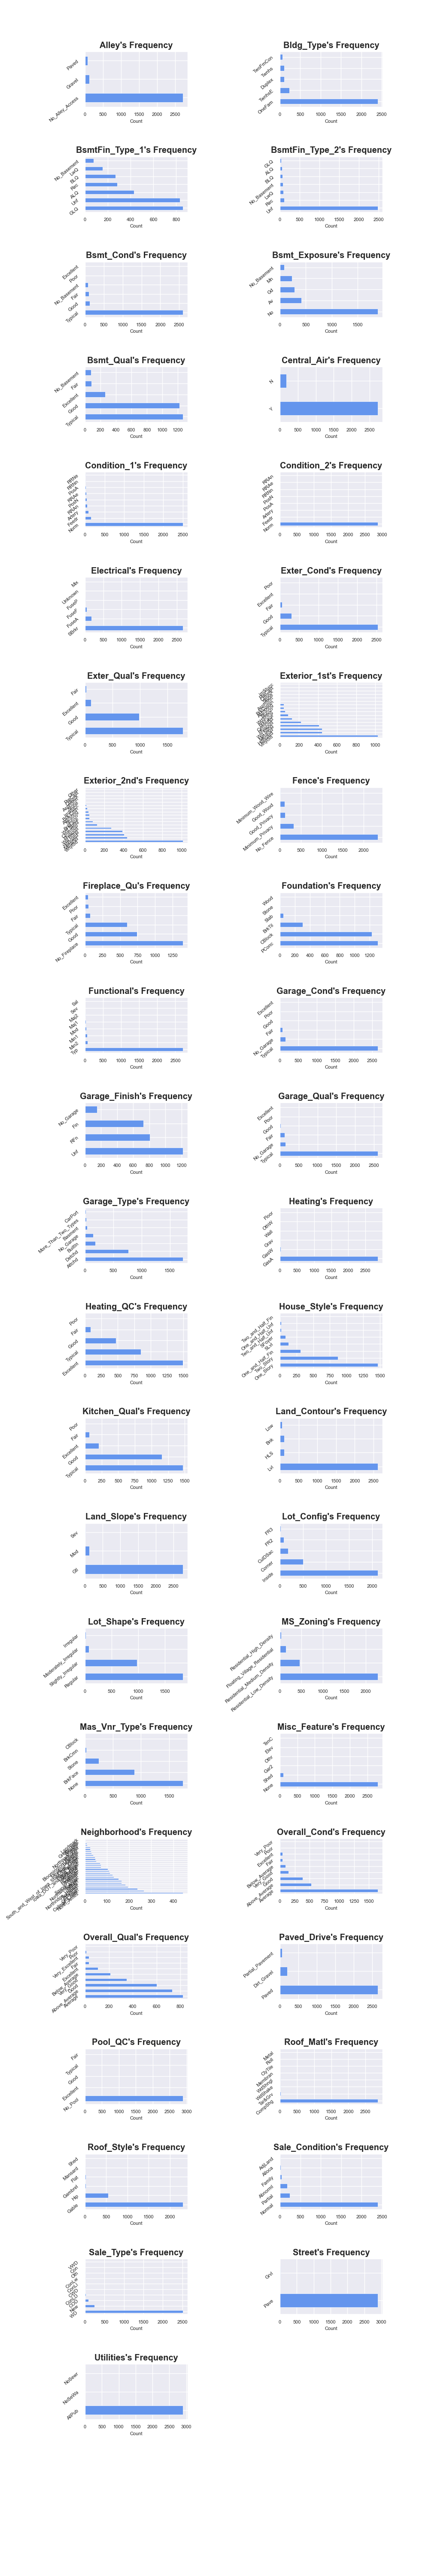

In [136]:
temp=df.copy()
decode_byte_str(dataset=temp)
barplot_categ(temp)

Even the categorical features have slightly improved!

### Save the dataset

We save the dataset locally to continue with the next part, the EDA.

In [137]:
df.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_0.csv"))

#### Credits and References
* Thomas Schmitt, [house_prices](https://www.openml.org/search?type=data&sort=runs&id=42165&status=active). OpenML (2019).(accessed April 12, 2023)
* E.J. Martin, [How much is my house worth? A beginner's guide]( https://www.bankrate.com/real-estate/how-much-is-my-house-worth/#faq). Bankrate (2023). (accessed April 12, 2023).
* J. Gomez, [8 critical factors that influence a home’s value](https://www.opendoor.com/articles/factors-that-influence-home-value). Opendoor (4 June 2022). (accessed April 12, 2023).
* [Ames (Iowa)](https://it.wikipedia.org/wiki/Ames_(Iowa)), Wikipedia (2020). (accessed April 12, 2023).
*  Leeclemmer, [Exploratory Data Analysis of Housing in Ames, Iowa](https://www.kaggle.com/code/leeclemmer/exploratory-data-analysis-of-housing-in-ames-iowa). Kaggle (2017). (accessed April 18, 2023).
